In [1]:
# 데이터 처리, 모델 구축, 시각화를 위한 주요 라이브러리 및 모듈을 불러옵니다.
import gc  # Python의 가비지 컬렉터 관련 모듈로, 메모리 관리를 위해 객체 삭제를 명시적으로 제어할 수 있습니다.
import itertools  # 반복 가능한 객체로부터 조합, 순열 등 다양한 반복자를 생성하는 유틸리티 모듈입니다.
import matplotlib.pyplot as plt  # 정적/애니메이션/인터랙티브 시각화를 지원하는 matplotlib의 핵심 시각화 도구입니다.
import numpy as np  # 다차원 배열과 행렬 연산, 다양한 수학 함수 제공을 위한 수치 계산 라이브러리입니다.
import pandas as pd  # 데이터 프레임과 시리즈 객체를 기반으로 한 데이터 분석용 라이브러리입니다.
import seaborn as sns  # matplotlib을 기반으로 한 고급 통계 시각화 라이브러리입니다.
import os  # 운영체제와 상호작용하기 위한 모듈로, 파일 경로 탐색 등 OS 의존 기능을 지원합니다.
import xgboost  # 머신러닝용 XGBoost 라이브러리 (주로 회귀, 분류, 랭킹에 사용).
import warnings  # 경고 메시지 필터링 및 제어를 위한 모듈입니다.
import lightgbm as lgbm  # LightGBM: 그래디언트 부스팅 기반 머신러닝 프레임워크입니다.
import lightgbm as lgb  # LightGBM을 다른 별칭으로 중복 임포트 (보통은 하나만 임포트해도 충분합니다).
import ctypes  # C 언어 호환 데이터 타입을 사용하거나 외부 DLL/공유 라이브러리 호출 시 사용되는 모듈입니다.
from sklearn.linear_model import LinearRegression  # 선형 회귀 모델을 구현하는 클래스입니다.

warnings.filterwarnings("ignore")  # 경고 메시지를 무시하여 출력 결과가 지저분하지 않도록 설정합니다.

c:\Users\lynn9\AppData\Local\Programs\Python\Python39\lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
# 쥬피터 노트북용 데이터 불러오기
df_train = pd.read_csv('C:/Users/lynn9/Desktop/data/sales_train.csv')
df_categories = pd.read_csv("C:/Users/lynn9/Desktop/data/item_categories.csv")
df_items = pd.read_csv("C:/Users/lynn9/Desktop/data/items-translated.csv", encoding='cp1252') # 번역 후 파일을 input 폴더에 올려두었습니다. 파일명: items_translated
df_shops = pd.read_csv("C:/Users/lynn9/Desktop/data/shops_graded.csv", encoding='cp1252') # ML코드에서는 shop_grade 컬럼을 사용하지 않아 버전2 업데이트 하지 않았습니다.
df_test = pd.read_csv("C:/Users/lynn9/Desktop/data/test.csv")
calendar = pd.read_csv("C:/Users/lynn9/Desktop/data/calendar.csv")

In [3]:
# 데이터 병합
df_train['date'] = pd.to_datetime(df_train['date'], format='%d.%m.%Y')
calendar['date'] = pd.to_datetime(calendar['date'])

df_train = pd.merge(df_train, df_items, on='item_id', how='inner')
df_train = pd.merge(df_train, df_categories, on='item_category_id', how='inner')
df_train = pd.merge(df_train, df_shops, on='shop_id', how='inner')
df_test = pd.merge(df_test, df_items, on='item_id', how='inner')
df_test = pd.merge(df_test, df_categories, on='item_category_id', how='inner')
df_test = pd.merge(df_test, df_shops, on='shop_id', how='inner')
df_train = pd.merge(df_train, calendar, on='date', how='left')

In [4]:
# category, shop 중분류 추가 (12초 소요)
df_train['city'] = df_train['shop_name'].str.split(' ').str[0]
df_train['sub_category'] = df_train['item_category_name'].str.split(' ').str[0]

# 중분류명 정리 → 13개
df_train['sub_category'] = df_train['sub_category'].replace({'Pure' : 'Carrier', 'Clean' : 'Carrier', 'Elements': 'Batteries', 'Payment' : 'Gift Card', 'Service' : 'Tickets', 'Android' : 'Games', 'Mac' : 'Games', 'Game' : 'Games'})

# city명 정리
df_train['city'] = df_train['city'].replace({'!' : 'Yakutsk', 'Exit' : 'Other', 'N.' : 'NizhnyNovgorod', 'SPb' : 'SanktPetersburg', 'Digital' : 'Online'})

# 원화 추가
df_train['total_amount'] = df_train['item_price'] * df_train['item_cnt_day'] # 판매 금액
df_train['krw_amount'] = df_train['total_amount'] * 18 # 국내 보고용 원화 표시, krw_amount로 표시
df_train = df_train.rename({'total_amount':'rub_amount'}, axis = 1)  # 기존 판매금액은 rub_amount로 표시

In [5]:
# date 관련 컬럼 추가 # 보고용이므로 예측에는 불필요 시 사용하지 않아도 됩니다. (7초 소요)
# df_train['date'] = pd.to_datetime(df_train['date'], format='%d.%m.%Y') (merge 직전에 완료)
df_train['year'] =  pd.to_datetime(df_train['date']).apply(lambda x : x.year)
df_train['month'] = pd.to_datetime(df_train['date']).apply(lambda x : x.month)
df_train['day'] = pd.to_datetime(df_train['date']).apply(lambda x : x.day)
df_train['year_month'] = df_train['date'].dt.to_period('M')

In [6]:
df_train[df_train.duplicated() == True]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name_translated,item_category_id,item_category_name,shop_name,...,holiday,weekend,city,sub_category,rub_amount,krw_amount,year,month,day,year_month
76962,2013-01-05,0,54,20130,149.0,1.0,SCIENTIFIC CHARODEA (region),40,Cinema - DVD,"Khimki shopping center ""mega""",...,0,1,Khimki,Cinema,149.0,2682.0,2013,1,5,2013-01
1435367,2014-02-23,13,50,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, Russian version]",23,Games - Xbox 360,"Tyumen TEC ""Goodwin""",...,1,1,Tyumen,Games,999.0,17982.0,2014,2,23,2014-02
1496766,2014-03-23,14,21,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, Russian version]",23,Games - Xbox 360,"Moscow MTRC ""Afers Mall""",...,0,1,Moscow,Games,999.0,17982.0,2014,3,23,2014-03
1671873,2014-05-01,16,50,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, Russian version]",23,Games - Xbox 360,"Tyumen TEC ""Goodwin""",...,1,0,Tyumen,Games,999.0,17982.0,2014,5,1,2014-05
1866340,2014-07-12,18,25,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, Russian version]",23,Games - Xbox 360,"Moscow TRK ""Atrium""",...,0,1,Moscow,Games,999.0,17982.0,2014,7,12,2014-07
2198566,2014-12-31,23,42,21619,499.0,1.0,THE MAN OF RAIN (BD),37,Cinema - Blu -Ray,"SPb TK ""Nevsky Center""",...,0,0,SanktPetersburg,Cinema,499.0,8982.0,2014,12,31,2014-12


In [7]:
# 중복 제거 # 6개 건
df_train.drop_duplicates(inplace=True)

In [ ]:
# df_train

In [8]:
test = pd.read_csv('C:/Users/lynn9/Desktop/data/test.csv')
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [9]:
data = df_train.copy()

In [ ]:
# data

In [10]:
data = data.drop(['shop_name', 'item_name_translated', 'item_category_name'], axis=1)
# 해당 컬럼들은 각 id컬럼과 1대1 매칭이므로 둘 중 하나는 제거

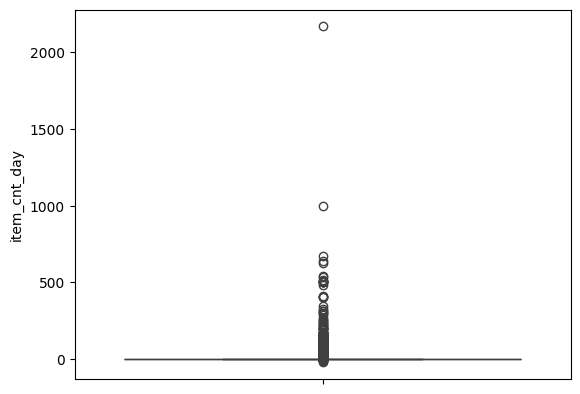

In [11]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

sns.boxplot(y='item_cnt_day', data=data);
plt.show()

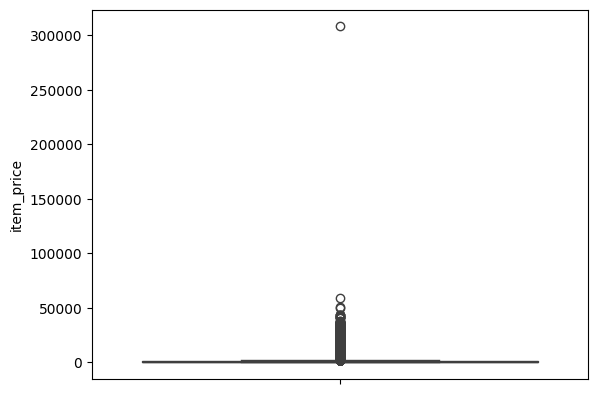

In [12]:
sns.boxplot(y='item_price', data=data);
plt.show()

## 이상치 제거

In [13]:
# 이상치 조건에 해당하는 행들 인덱스 추출
outlier_condition = (data['item_cnt_day'] >= 1000) | (data['item_price'] >= 100000)

# 이상치가 아닌 데이터만 필터링
data_cleaned = data[~outlier_condition].copy()
print(data_cleaned.shape)

(2935840, 18)


## 결측치 확인

In [14]:
data_cleaned.isna().sum() # 결측치 없음

date                0
date_block_num      0
shop_id             0
item_id             0
item_price          0
item_cnt_day        0
item_category_id    0
shop_grade          0
holiday             0
weekend             0
city                0
sub_category        0
rub_amount          0
krw_amount          0
year                0
month               0
day                 0
year_month          0
dtype: int64

In [15]:
# 그룹화하여 월별 월간 판매량
group = data_cleaned.groupby('date_block_num').agg({'item_cnt_day': 'sum'})
group.reset_index() # 인덱스 재설정

,date_block_num,item_cnt_day
0,0,131478.0
1,1,128090.0
2,2,147142.0
3,3,107190.0
4,4,106970.0
5,5,125381.0
6,6,116966.0
7,7,125291.0
8,8,133332.0
9,9,127541.0


In [16]:
from itertools import product

train = []
# 월ID, 상점ID, 상품ID 조합 생성 
for i in data_cleaned['date_block_num'].unique():
    all_shop = data_cleaned.loc[data_cleaned['date_block_num']==i, 'shop_id'].unique()
    all_item = data_cleaned.loc[data_cleaned['date_block_num']==i, 'item_id'].unique()
    train.append(np.array(list(product([i], all_shop, all_item))))

idx_features = ['date_block_num', 'shop_id', 'item_id'] # 기준 피처
# 리스트 타입인 train을 DataFrame 타입으로 변환 
train = pd.DataFrame(np.vstack(train), columns=idx_features)

train

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564
...,...,...,...
10913799,33,21,7635
10913800,33,21,7638
10913801,33,21,7640
10913802,33,21,7632


## 피처엔지니어링 target값 추가 (월간 판매량)

In [17]:
# idx_features를 기준으로 그룹화해 판매량 합 구하기 
group = data_cleaned.groupby(idx_features).agg({'item_cnt_day': 'sum'})
# 인덱스 재설정
group = group.reset_index()
# '판매량'에서 '월간 판매량'
group = group.rename(columns={'item_cnt_day': 'item_cnt_monthly'})

group

,date_block_num,shop_id,item_id,item_cnt_monthly
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0
...,...,...,...,...
1609117,33,59,22087,6.0
1609118,33,59,22088,2.0
1609119,33,59,22091,1.0
1609120,33,59,22100,1.0


In [18]:
# train과 group 병합
train = train.merge(group, on=idx_features, how='left')
train

,date_block_num,shop_id,item_id,item_cnt_monthly
0,0,59,22154,1.0
1,0,59,2552,NaN
2,0,59,2554,NaN
3,0,59,2555,NaN
4,0,59,2564,NaN
...,...,...,...,...
10913799,33,21,7635,NaN
10913800,33,21,7638,NaN
10913801,33,21,7640,NaN
10913802,33,21,7632,NaN


### 가비지 컬렉터 수행

In [19]:
import gc # 가비지 컬렉터

del group # 더는 사용하지 않는 변수 지정
gc.collect(); # 가비지 컬렉션 수행

### Feature Engineering test data 이어붙이기
train data의 월ID는 0~33으로 마지막이 2015년 10월인데, test data는 2015년 11월이므로 월ID feature를 34로 설정한다.  
test data에서 식별자 역할을 하는 ID를 제외하고 test data를 train data와 merge

In [20]:
test['date_block_num'] = 34  # 2015년 11월 예측 대상

all_data = pd.concat([train, test.drop('ID', axis=1)],
                     ignore_index=True, 
                     keys=idx_features) # 이어붙이는 기준이 되는 피처

# 결측값 0으로 채우기
all_data = all_data.fillna(0)

all_data.head()

,date_block_num,shop_id,item_id,item_cnt_monthly
0,0,59,22154,1.0
1,0,59,2552,0.0
2,0,59,2554,0.0
3,0,59,2555,0.0
4,0,59,2564,0.0


### Feature Engineering 나머지 데이터 병합 (최종 데이터 생성)

In [ ]:
# all_data

In [21]:
import numpy as np
import pandas as pd

def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        dtype = df[col].dtype

        if pd.api.types.is_object_dtype(dtype):
            # object는 건너뜀
            continue
        elif pd.api.types.is_bool_dtype(dtype):
            df[col] = df[col].astype('int8')
        elif pd.api.types.is_integer_dtype(dtype):
            df[col] = pd.to_numeric(df[col], downcast='integer')
        elif pd.api.types.is_float_dtype(dtype):
            # 소수점이 없는 float는 int로 변환
            col_non_na = df[col].dropna()
            if (col_non_na == col_non_na.astype(int)).all():
                df[col] = pd.to_numeric(df[col], downcast='integer')
            else:
                df[col] = pd.to_numeric(df[col], downcast='float')
        else:
            # 예: datetime, category 등은 건너뜀
            continue

    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% 압축됨'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [22]:
all_df = [df_train, df_shops, df_items, df_categories, test]
for df in all_df:
    df = downcast(df)

38.1% 압축됨
26.8% 압축됨
54.2% 압축됨
39.9% 압축됨
75.0% 압축됨


In [23]:
all_data = all_data.merge(df_shops, on='shop_id', how='left')
all_data = all_data.merge(df_items, on='item_id', how='left')
all_data = all_data.merge(df_categories, on='item_category_id', how='left')
all_data = all_data.drop(['shop_name', 'item_name_translated', 'item_category_name'], axis=1)
# 데이터 다운캐스팅
all_data = downcast(all_data)

# # 가비지 컬렉션
# del df_shops, df_items, df_categories
# # del df_shops, df_categories # df_items -> 아래에서 사용하므로 버리지 않음
# gc.collect();

63.4% 압축됨


In [24]:
# 훈련 데이터 (피처)
X_train = all_data[all_data['date_block_num'] < 33]
X_train = X_train.drop(['item_cnt_monthly'], axis=1)
# 검증 데이터 (피처)
X_valid = all_data[all_data['date_block_num'] == 33]
X_valid = X_valid.drop(['item_cnt_monthly'], axis=1)
# 테스트 데이터 (피처)
X_test = all_data[all_data['date_block_num'] == 34]
X_test = X_test.drop(['item_cnt_monthly'], axis=1)

# 훈련 데이터 (타깃값)
y_train = all_data[all_data['date_block_num'] < 33]['item_cnt_monthly']
y_train = y_train.clip(0, 20) # 타깃값을 0 ~ 20로 제한
# 검증 데이터 (타깃값)
y_valid = all_data[all_data['date_block_num'] == 33]['item_cnt_monthly']
y_valid = y_valid.clip(0, 20)

학습 데이터 X_train, y_train : 33월 이전 데이터로 학습  
검증 데이터 X_valid, y_valid : 33월 데이터로 모델 검증  
테스트 데이터 X_test: 34월 데이터로 예측 (34월: 2015년 11월)

In [25]:
X_train.shape

(10675632, 5)

In [26]:
y_train.shape

(10675632,)

In [27]:
X_valid.shape

(238172, 5)

In [28]:
y_valid.shape

(238172,)

In [29]:
X_train = X_train.drop('shop_grade', axis=1)
X_valid = X_valid.drop('shop_grade', axis=1)
X_test = X_test.drop('shop_grade', axis=1)

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

model = LinearRegression()
model.fit(X_train, y_train)

y_pred_valid = model.predict(X_valid)
y_pred_valid = np.clip(y_pred_valid, 0, 20)
mse = mean_squared_error(y_valid, y_pred_valid)
rmse = np.sqrt(mse)

print(f"검증 RMSE: {rmse:.4f}")
# y_pred_test = model.predict(X_test)

검증 RMSE: 1.1368


In [31]:
y_pred_test = model.predict(X_test)

y_pred_test = model.predict(X_test)
y_pred_test = np.clip(y_pred_test, 0, 20)

print(y_pred_test)

[0.44613277 0.20819708 0.44453035 ... 0.19413805 0.26050265 0.4328497 ]


## 성능 개선 개별 데이터 피처 엔지니어링

### 이상치 제거 및 전처리

In [32]:
df_train.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name_translated,item_category_id,item_category_name,shop_name,...,holiday,weekend,city,sub_category,rub_amount,krw_amount,year,month,day,year_month
0,2013-01-02,0,59,22154,999.0,1,SCENE 2012 (BD),37,Cinema - Blu -Ray,"Yaroslavl shopping center ""Altair""",...,1,0,Yaroslavl,Cinema,999.0,17982.0,2013,1,2,2013-01
1,2013-01-03,0,25,2552,899.0,1,DEEP PURPLE The House Of Blue Light LP,58,Music - vinyl,"Moscow TRK ""Atrium""",...,1,0,Moscow,Music,899.0,16182.0,2013,1,3,2013-01
2,2013-01-05,0,25,2552,899.0,-1,DEEP PURPLE The House Of Blue Light LP,58,Music - vinyl,"Moscow TRK ""Atrium""",...,0,1,Moscow,Music,-899.0,-16182.0,2013,1,5,2013-01


In [33]:
# 판매가가 0보다 큰 데이터 추출
df_train = df_train[df_train['item_price'] > 0]
# 판매가가 50,000보다 작은 데이터 추출
df_train = df_train[df_train['item_price'] < 50000]

# 판매량이 0보다 큰 데이터 추출
df_train = df_train[df_train['item_cnt_day'] > 0]
# 판매량이 1,000보다 작은 데이터 추출
df_train = df_train[df_train['item_cnt_day'] < 1000]

상점명을 조금 다르게 기입해서 같은 상점인데 다르게 기록되어 있는 상점이 4쌍 있기에 각 쌍의 상점ID를 수정해준다. 상점명은 어차피 제거할 것이기에 수정하지 않아도 된다. -> 수정하지않음

### 도시명은 범주형 피처이므로 레이블 인코딩

In [34]:
# df_train에서 shop_id와 city 정보만 추출 후 중복 제거
shop_city_map = df_train[['shop_id', 'city']].drop_duplicates()

# df_shops가 안 불러와지니까 shop_id만 따로 생성한 뒤 병합
shops = pd.DataFrame({'shop_id': df_train['shop_id'].unique()})
shops = shops.merge(shop_city_map, on='shop_id', how='left')

In [35]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
shops['city'] = label_encoder.fit_transform(shops['city'])

In [36]:
# # item_id별 첫 판매 월 추출
# first_sales_month = df_train.groupby('item_id', as_index=False)['date_block_num'].min()
# first_sales_month.rename(columns={'date_block_num': 'first_sales_month'}, inplace=True)

# # 새로운 DataFrame 생성
# items = first_sales_month.copy()

In [36]:
# item_id별 첫 판매 월 추출
first_sales_month = df_train.groupby('item_id', as_index=False)['date_block_num'].min()
first_sales_month.rename(columns={'date_block_num': 'first_sales_month'}, inplace=True)

# item_id별 item_category_id 추출 (중복 제거)
item_categories = df_train[['item_id', 'item_category_id']].drop_duplicates()

# first_sales_month와 item_category_id 합치기
items = first_sales_month.merge(item_categories, on='item_id', how='left')

In [37]:
items.head(3)

,item_id,first_sales_month,item_category_id
0,0,20,40
1,1,15,76
2,2,19,40


In [38]:
items['first_sales_month'].isna().sum()

0

In [39]:
# item_category_id와 sub_category 정보를 df_train에서 추출 후 중복 제거
item_categories = df_train[['item_category_id', 'sub_category']].drop_duplicates().reset_index(drop=True)

In [40]:
# 레이블 인코더 생성
label_encoder = LabelEncoder()

# 대분류 피처 레이블 인코딩
item_categories['sub_category'] = label_encoder.fit_transform(item_categories['sub_category'])

In [ ]:
# shops -> shop_id, city
# items -> item_id, first_sales_month, item_category_id
# item_categories -> item_category_id, sub_category

### 파생 변수 생성
월, 상점, 상품별 월간 판매량과 평균 판매가 변수를 만들고, 기준 feature별 상품 판매건수 feature를 만들어 준다.

In [41]:
# 충돌 방지를 위해 기존 컬럼 삭제
train = train.drop(columns=['item_cnt_monthly'], errors='ignore')

group = df_train.groupby(idx_features).agg({'item_cnt_day': 'sum',
                                               'item_price': 'mean'})
group = group.reset_index()
group = group.rename(columns={'item_cnt_day': 'item_cnt_monthly', 'item_price': 'mean_item_price'})

train = train.merge(group, on=idx_features, how='left')

train.head()

,date_block_num,shop_id,item_id,item_cnt_monthly,mean_item_price
0,0,59,22154,1.0,999.0
1,0,59,2552,NaN,NaN
2,0,59,2554,NaN,NaN
3,0,59,2555,NaN,NaN
4,0,59,2564,NaN,NaN


### test data를 train에 합치기

In [42]:
# 테스트 데이터 월ID를 34로 설정
test['date_block_num'] = 34

# train과 test 이어붙이기
all_data = pd.concat([train, test.drop('ID', axis=1)],
                     ignore_index=True,
                     keys=idx_features)
# 결측값을 0으로 대체
all_data = all_data.fillna(0)

all_data.head()

,date_block_num,shop_id,item_id,item_cnt_monthly,mean_item_price
0,0,59,22154,1.0,999.0
1,0,59,2552,0.0,0.0
2,0,59,2554,0.0,0.0
3,0,59,2555,0.0,0.0
4,0,59,2564,0.0,0.0


item_cnt_monthly컬럼이 하나가 되어야 함 -> ok  
판매건수가 붙어있지 않음 

In [47]:
# # 테스트 데이터 월ID를 34로 설정
# test['date_block_num'] = 34

# # train과 test 이어붙이기
# all_data = pd.concat([train, test.drop('ID', axis=1)],
#                      ignore_index=True,
#                      keys=idx_features)
# # 결측값을 0으로 대체
# all_data = all_data.fillna(0)

# all_data.head()

판매건수가 붙지 않는 문제 발생 -> 일단 진행 -> 판매건수가 item_cnt_day이면 해결
all_data에 item_category_id가 없어서 merge가 안 됨 -> merge 하여 해결 

In [43]:
print(items['item_id'].duplicated().sum())

0


In [44]:
all_data.isna().sum()

date_block_num      0
shop_id             0
item_id             0
item_cnt_monthly    0
mean_item_price     0
dtype: int64

In [45]:
all_data['item_id'].nunique()

22169

In [46]:
items['item_id'].nunique()

21802

In [47]:
all_data = all_data.merge(items, on='item_id', how='left')

In [48]:
print(all_data[['item_id', 'first_sales_month']].isna().sum())

item_id                  0
first_sales_month    15430
dtype: int64


In [49]:
all_data = all_data[all_data['first_sales_month'].notna()].reset_index(drop=True) # 결측치는 drop or fillna(0) 중에 제거 선택

In [50]:
print(all_data[['item_id', 'first_sales_month']].isna().sum())

item_id              0
first_sales_month    0
dtype: int64


In [56]:
# all_data

In [51]:
all_data = all_data.merge(shops, on='shop_id', how='left')
all_data = all_data.merge(item_categories, on='item_category_id', how='left')

In [52]:
merge_df = all_data.copy() # 혹시 몰라서 copy

In [53]:
all_data = downcast(all_data)

71.9% 압축됨


In [54]:
del shops, items, item_categories
# del shops, item_categories
gc.collect();

In [55]:
all_data

,date_block_num,shop_id,item_id,item_cnt_monthly,mean_item_price,first_sales_month,item_category_id,city,sub_category
0,0,59,22154,1,999.0,0,37,28,4
1,0,59,2552,0,0.0,0,58,28,9
2,0,59,2554,0,0.0,0,58,28,9
3,0,59,2555,0,0.0,0,56,28,9
4,0,59,2564,0,0.0,0,59,28,9
...,...,...,...,...,...,...,...,...,...
11112569,34,45,18454,0,0.0,23,55,17,9
11112570,34,45,16188,0,0.0,32,64,17,8
11112571,34,45,15757,0,0.0,0,55,17,9
11112572,34,45,19648,0,0.0,23,40,17,4


### 시차(time lag) feature 생성
타깃값과 관련된 "기준 feauture별 월간 평균 판매량" feature를 만들고 이를 활용해 시차 feature를 만들도록한다.

In [56]:
def add_mean_features(df, mean_features, idx_features): # df->all_data
    # 기준 피처 확인 
    assert (idx_features[0] == 'date_block_num') and \
           len(idx_features) in [2, 3]

    # 파생 피처명 설정 
    if len(idx_features) == 2:
        feature_name = idx_features[1] + '별 평균 판매량'
    else:
        feature_name = idx_features[1] + ' ' + idx_features[2] + '별 평균 판매량'

    # 기준 피처를 토대로 그룹화해 월간 평균 판매량 구하기 
    group = df.groupby(idx_features).agg({'item_cnt_monthly': 'mean'})
    group = group.reset_index()
    group = group.rename(columns={'item_cnt_monthly': feature_name})

    # df와 group 병합 
    df = df.merge(group, on=idx_features, how='left')
    # 데이터 다운캐스팅 
    df = downcast(df, verbose=False)
    # 새로 만든 feature_name 피처명을 mean_features 리스트에 추가 
    mean_features.append(feature_name)

    # 가비지 컬렉션
    del group
    gc.collect()

    return df, mean_features

In [63]:
# # 테스트 데이터 월ID를 34로 설정
# test['date_block_num'] = 34

# # train과 test 이어붙이기
# all_data = pd.concat([train, test.drop('ID', axis=1)],
#                      ignore_index=True,
#                      keys=idx_features)
# # 결측값을 0으로 대체
# all_data = all_data.fillna(0)

# all_data.head()

여기서 이 셀을 지나면 all_data가 reset되는 문제 -> 일단 지나게 해서 추후에 merge하는 방법

In [57]:
test['date_block_num'] = 34
all_data = pd.concat([train, test.drop('ID', axis=1)], ignore_index=True)
all_data = all_data.fillna(0)
all_data.head()

,date_block_num,shop_id,item_id,item_cnt_monthly,mean_item_price
0,0,59,22154,1.0,999.0
1,0,59,2552,0.0,0.0
2,0,59,2554,0.0,0.0
3,0,59,2555,0.0,0.0
4,0,59,2564,0.0,0.0


In [65]:
# # test에 train의 컬럼 구조를 맞춰줌 -> test에 없는 컬럼이 fillna 되지 않게 함
# for col in train.columns:
#     if col not in test.columns and col != 'ID':
#         test[col] = np.nan

# test['date_block_num'] = 34

# # 합치기
# all_data = pd.concat([train, test.drop('ID', axis=1)], ignore_index=True)
# all_data = all_data.fillna(0)

In [58]:
# all_data와 df_train에 모두 존재하는 'shop_id'컬럼을 기준으로 병합
# df_train에서 중복 제거 후 city 컬럼만 추출
shop_city = df_train[['shop_id', 'city']].drop_duplicates()

# all_data에 병합 (중복 컬럼 방지)
all_data = all_data.merge(shop_city, on='shop_id', how='left')

all_data에 city컬럼을 merge 하였으므로 아래 행이 실행되어야 함 -> ok

In [59]:
# 그룹화 기준 피처 중 '상품ID'가 포함된 파생 피처명을 담을 리스트
item_mean_features = []

# ['월ID', '상품ID']로 그룹화한 월간 평균 판매량 파생 피처 생성
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['date_block_num', 'item_id'])

# ['월ID', '상품ID', '도시']로 그룹화한 월간 평균 판매량 파생 피처 생성
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['date_block_num', 'item_id', 'city'])

item_mean_features

['item_id별 평균 판매량', 'item_id city별 평균 판매량']

In [60]:
# item_id 기준으로 item_category_id 병합
item_category = df_train[['item_id', 'item_category_id']].drop_duplicates()
all_data = all_data.merge(item_category, on='item_id', how='left')

In [61]:
# 그룹화 기준 피처 중 '상점ID'가 포함된 파생 피처명을 담을 리스트
shop_mean_features = []

# ['월ID', '상점ID', '상품분류ID']로 그룹화한 월간 평균 판매량 파생 피처 생성
all_data, shop_mean_features = add_mean_features(df=all_data, 
                                                 mean_features=shop_mean_features,
                                                 idx_features=['date_block_num', 'shop_id', 'item_category_id'])

shop_mean_features

['shop_id item_category_id별 평균 판매량']

In [62]:
def add_lag_features(df, lag_features_to_clip, idx_features, 
                     lag_feature, nlags=3, clip=False):
    df_temp = df[idx_features + [lag_feature]].copy()

    for i in range(1, nlags + 1):
        lag_feature_name = lag_feature + '_시차' + str(i)

        # 중복 컬럼 있으면 제거
        if lag_feature_name in df.columns:
            df = df.drop(columns=[lag_feature_name])
            # df_temp, df 모두 컬럼이 존재하여 중복 문제로 하나는 거거

        df_temp.columns = idx_features + [lag_feature_name]
        df_temp['date_block_num'] += 1

        df = df.merge(df_temp.drop_duplicates(), on=idx_features, how='left')

        df[lag_feature_name] = df[lag_feature_name].fillna(0)

        if clip:
            lag_features_to_clip.append(lag_feature_name)

    df = downcast(df, False)
    del df_temp
    gc.collect()

    return df, lag_features_to_clip

In [63]:
lag_features_to_clip = [] # 0 ~ 20 사이로 제한할 시차 피처명을 담을 리스트
idx_features = ['date_block_num', 'shop_id', 'item_id'] # 기준 피처

# idx_features를 기준으로 월간 판매량의 세 달치 시차 피처 생성
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='item_cnt_monthly', 
                                                  nlags=3,
                                                  clip=True) # 값을 0 ~ 20 사이로 제한

In [64]:
# idx_features를 기준으로 판매건수 피처의 세 달치 시차 피처 생성
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='item_cnt_monthly', 
                                                  nlags=3)

# idx_features를 기준으로 평균 판매가 피처의 세 달치 시차 피처 생성
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='mean_item_price', 
                                                  nlags=3)

In [73]:
# all_data

In [65]:
print(all_data.columns.tolist()) 

['date_block_num', 'shop_id', 'item_id', 'item_cnt_monthly', 'mean_item_price', 'city', 'item_id별 평균 판매량', 'item_id city별 평균 판매량', 'item_category_id', 'shop_id item_category_id별 평균 판매량', 'item_cnt_monthly_시차1', 'item_cnt_monthly_시차2', 'item_cnt_monthly_시차3', 'mean_item_price_시차1', 'mean_item_price_시차2', 'mean_item_price_시차3']


In [66]:
# idx_features를 기준으로 item_mean_features 요소별 시차 피처 생성
for item_mean_feature in item_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      idx_features=idx_features, 
                                                      lag_feature=item_mean_feature, 
                                                      nlags=3,
                                                      clip=True)
# item_mean_features 피처 제거
all_data = all_data.drop(item_mean_features, axis=1)

In [67]:
# ['월ID', '상점ID', '상품분류ID']를 기준으로 shop_mean_features 요소별 시차 피처 생성
for shop_mean_feature in shop_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data,
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      idx_features=['date_block_num', 'shop_id', 'item_id'], 
                                                      lag_feature=shop_mean_feature, 
                                                      nlags=3,
                                                      clip=True)
# shop_mean_features 피처 제거
all_data = all_data.drop(shop_mean_features, axis=1)

In [68]:
# 월ID 3미만인 데이터 제거
all_data = all_data.drop(all_data[all_data['date_block_num'] < 3].index)

In [78]:
# all_data

### 기타 feature engineering

In [69]:
pd.set_option('display.max_columns', None)
all_data

,date_block_num,shop_id,item_id,item_cnt_monthly,mean_item_price,city,item_category_id,item_cnt_monthly_시차1,item_cnt_monthly_시차2,item_cnt_monthly_시차3,mean_item_price_시차1,mean_item_price_시차2,mean_item_price_시차3,item_id별 평균 판매량_시차1,item_id별 평균 판매량_시차2,item_id별 평균 판매량_시차3,item_id city별 평균 판매량_시차1,item_id city별 평균 판매량_시차2,item_id city별 평균 판매량_시차3,shop_id item_category_id별 평균 판매량_시차1,shop_id item_category_id별 평균 판매량_시차2,shop_id item_category_id별 평균 판매량_시차3
1122795,3,25,8092,3,149.0,Moscow,40.0,1,0,4,149.0,0.0,149.0,0.586957,0.630435,1.444444,0.666667,0.666667,2.000000,1.035039,0.899247,0.995823
1122796,3,25,7850,3,199.0,Moscow,30.0,5,1,6,199.0,199.0,199.0,1.869565,1.456522,3.088889,2.916667,2.083333,2.916667,3.554645,2.083532,2.163855
1122797,3,25,8051,3,30.0,Moscow,66.0,0,0,0,0.0,0.0,0.0,0.043478,0.130435,0.133333,0.000000,0.333333,0.333333,1.796610,2.175439,1.320000
1122798,3,25,8088,1,199.0,Moscow,55.0,1,1,0,199.0,199.0,0.0,0.130435,0.043478,0.066667,0.166667,0.083333,0.000000,0.569322,0.544919,0.534779
1122799,3,25,8089,1,199.0,Moscow,55.0,0,1,0,0.0,199.0,0.0,0.478261,0.260870,0.177778,0.666667,0.250000,0.083333,0.569322,0.544919,0.534779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11127999,34,45,18454,0,0.0,Samara,55.0,1,0,0,99.0,0.0,0.0,0.045455,0.023256,0.071429,0.500000,0.000000,0.000000,0.126866,0.074534,0.106061
11128000,34,45,16188,0,0.0,Samara,64.0,0,0,0,0.0,0.0,0.0,0.022727,0.069767,0.000000,0.000000,0.000000,0.000000,0.094488,0.117117,0.000000
11128001,34,45,15757,0,0.0,Samara,55.0,0,0,0,0.0,0.0,0.0,0.113636,0.069767,0.095238,0.000000,0.500000,0.000000,0.126866,0.074534,0.106061
11128002,34,45,19648,0,0.0,Samara,40.0,0,0,0,0.0,0.0,0.0,0.045455,0.069767,0.166667,0.000000,0.000000,0.000000,0.083756,0.074074,0.111645


In [70]:
all_data['월간 판매량 시차평균'] = all_data[['item_cnt_monthly_시차1',
                                          'item_cnt_monthly_시차2', 
                                          'item_cnt_monthly_시차3']].mean(axis=1)

In [71]:
# 0 ~ 20 사이로 값 제한
all_data[lag_features_to_clip + ['item_cnt_monthly', '월간 판매량 시차평균']] = all_data[lag_features_to_clip + ['item_cnt_monthly', '월간 판매량 시차평균']].clip(0, 20)

월간판매량 -> item_cnt_monthly 로 바꿔야 할 것 같은데 오류 날까봐 일단 둠 -> 수정해서 오류 해결

In [72]:
all_data['시차변화량1'] = all_data['item_cnt_monthly_시차1']/all_data['item_cnt_monthly_시차2']
all_data['시차변화량1'] = all_data['시차변화량1'].replace([np.inf, -np.inf], 
                                                        np.nan).fillna(0)

all_data['시차변화량2'] = all_data['item_cnt_monthly_시차2']/all_data['item_cnt_monthly_시차3']
all_data['시차변화량2'] = all_data['시차변화량2'].replace([np.inf, -np.inf], 
                                                        np.nan).fillna(0)

In [73]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10005209 entries, 1122795 to 11128003
Data columns (total 25 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   date_block_num                        int8   
 1   shop_id                               int8   
 2   item_id                               int16  
 3   item_cnt_monthly                      int16  
 4   mean_item_price                       float64
 5   city                                  object 
 6   item_category_id                      float64
 7   item_cnt_monthly_시차1                  int16  
 8   item_cnt_monthly_시차2                  int16  
 9   item_cnt_monthly_시차3                  int16  
 10  mean_item_price_시차1                   float64
 11  mean_item_price_시차2                   float64
 12  mean_item_price_시차3                   float64
 13  item_id별 평균 판매량_시차1                   float32
 14  item_id별 평균 판매량_시차2                   float32
 15  item_id

In [74]:
all_data.isna().sum()

date_block_num                              0
shop_id                                     0
item_id                                     0
item_cnt_monthly                            0
mean_item_price                             0
city                                        0
item_category_id                        15339
item_cnt_monthly_시차1                        0
item_cnt_monthly_시차2                        0
item_cnt_monthly_시차3                        0
mean_item_price_시차1                         0
mean_item_price_시차2                         0
mean_item_price_시차3                         0
item_id별 평균 판매량_시차1                         0
item_id별 평균 판매량_시차2                         0
item_id별 평균 판매량_시차3                         0
item_id city별 평균 판매량_시차1                    0
item_id city별 평균 판매량_시차2                    0
item_id city별 평균 판매량_시차3                    0
shop_id item_category_id별 평균 판매량_시차1        0
shop_id item_category_id별 평균 판매량_시차2        0
shop_id item_category_id별 평균 판매량_시

In [75]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11112574 entries, 0 to 11112573
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   date_block_num     int64  
 1   shop_id            int64  
 2   item_id            int64  
 3   item_cnt_monthly   float64
 4   mean_item_price    float64
 5   first_sales_month  float64
 6   item_category_id   float64
 7   city               int32  
 8   sub_category       int32  
dtypes: float64(4), int32(2), int64(3)
memory usage: 678.3 MB


In [76]:
merge_df_filtered = merge_df[['item_id', 'first_sales_month', 'sub_category']].drop_duplicates('item_id')

# NaN 허용되는 정수형으로 변환
merge_df_filtered['first_sales_month'] = merge_df_filtered['first_sales_month'].astype('Int8')
merge_df_filtered['sub_category'] = merge_df_filtered['sub_category'].astype('Int8')

# 기존 컬럼 제거 (있다면)
for col in ['first_sales_month', 'sub_category']:
    if col in all_data.columns:
        all_data = all_data.drop(columns=col)

# merge
all_data = all_data.merge(merge_df_filtered, on='item_id', how='left')

In [77]:
all_data['신상여부'] = all_data['first_sales_month'] == all_data['date_block_num']

In [78]:
all_data['월'] = all_data['date_block_num'] % 12

In [79]:
all_data.isna().sum()

date_block_num                              0
shop_id                                     0
item_id                                     0
item_cnt_monthly                            0
mean_item_price                             0
city                                        0
item_category_id                        15339
item_cnt_monthly_시차1                        0
item_cnt_monthly_시차2                        0
item_cnt_monthly_시차3                        0
mean_item_price_시차1                         0
mean_item_price_시차2                         0
mean_item_price_시차3                         0
item_id별 평균 판매량_시차1                         0
item_id별 평균 판매량_시차2                         0
item_id별 평균 판매량_시차3                         0
item_id city별 평균 판매량_시차1                    0
item_id city별 평균 판매량_시차2                    0
item_id city별 평균 판매량_시차3                    0
shop_id item_category_id별 평균 판매량_시차1        0
shop_id item_category_id별 평균 판매량_시차2        0
shop_id item_category_id별 평균 판매량_시

In [90]:
# # 첫 판매월, 평균 판매가, 판매건수 피처 제거
# all_data = all_data.drop(['first_sales_month', 'mean_item_price', 'item_cnt_monthly'], axis=1)

In [80]:
all_data.isna().sum()

date_block_num                              0
shop_id                                     0
item_id                                     0
item_cnt_monthly                            0
mean_item_price                             0
city                                        0
item_category_id                        15339
item_cnt_monthly_시차1                        0
item_cnt_monthly_시차2                        0
item_cnt_monthly_시차3                        0
mean_item_price_시차1                         0
mean_item_price_시차2                         0
mean_item_price_시차3                         0
item_id별 평균 판매량_시차1                         0
item_id별 평균 판매량_시차2                         0
item_id별 평균 판매량_시차3                         0
item_id city별 평균 판매량_시차1                    0
item_id city별 평균 판매량_시차2                    0
item_id city별 평균 판매량_시차3                    0
shop_id item_category_id별 평균 판매량_시차1        0
shop_id item_category_id별 평균 판매량_시차2        0
shop_id item_category_id별 평균 판매량_시

In [81]:
# 결측치가 생긴 컬럼 리스트
cols_with_na = ['item_category_id', 'sub_category', '신상여부']

# 결측치가 하나라도 있는 행 제거
all_data = all_data.dropna(subset=cols_with_na).reset_index(drop=True)

In [82]:
all_data.isna().sum()

date_block_num                          0
shop_id                                 0
item_id                                 0
item_cnt_monthly                        0
mean_item_price                         0
city                                    0
item_category_id                        0
item_cnt_monthly_시차1                    0
item_cnt_monthly_시차2                    0
item_cnt_monthly_시차3                    0
mean_item_price_시차1                     0
mean_item_price_시차2                     0
mean_item_price_시차3                     0
item_id별 평균 판매량_시차1                     0
item_id별 평균 판매량_시차2                     0
item_id별 평균 판매량_시차3                     0
item_id city별 평균 판매량_시차1                0
item_id city별 평균 판매량_시차2                0
item_id city별 평균 판매량_시차3                0
shop_id item_category_id별 평균 판매량_시차1    0
shop_id item_category_id별 평균 판매량_시차2    0
shop_id item_category_id별 평균 판매량_시차3    0
월간 판매량 시차평균                             0
시차변화량1                            

In [83]:
from sklearn.preprocessing import LabelEncoder

# 레이블 인코더 생성
label_encoder = LabelEncoder()

# 도시 피처 레이블 인코딩
all_data['city'] = label_encoder.fit_transform(all_data['city'])

In [84]:
all_data = downcast(all_data, False) # 데이터 다운캐스팅

In [85]:
# 타깃값 (item_cnt_monthly) 먼저 분리
y_train = all_data.loc[all_data['date_block_num'] < 33, 'item_cnt_monthly']
y_valid = all_data.loc[all_data['date_block_num'] == 33, 'item_cnt_monthly']

# 예측에 필요 없는 피처 제거 (타깃과 누설 가능성 있는 것들)
all_data = all_data.drop(['first_sales_month', 'mean_item_price', 'item_cnt_monthly'], axis=1)

# 학습/검증/테스트용 피처 데이터 분리
X_train = all_data[all_data['date_block_num'] < 33]
X_valid = all_data[all_data['date_block_num'] == 33]
X_test = all_data[all_data['date_block_num'] == 34]

# 메모리 정리
del all_data
gc.collect()

0

In [86]:
print("y_train shape:", y_train.shape)
print("y_valid shape:", y_valid.shape)

print("X_train shape:", X_train.shape)
print("X_valid shape:", X_valid.shape)
print("X_test shape:", X_test.shape)

y_train shape: (9552744,)
y_valid shape: (238172,)
X_train shape: (9552744, 26)
X_valid shape: (238172, 26)
X_test shape: (198954, 26)


In [87]:
print("y_train stats:")
print(y_train.describe())

print("y_valid stats:")
print(y_valid.describe())

y_train stats:
count    9.552744e+06
mean     2.946082e-01
std      1.212860e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.000000e+01
Name: item_cnt_monthly, dtype: float64
y_valid stats:
count    238172.000000
mean          0.259056
std           1.137015
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          20.000000
Name: item_cnt_monthly, dtype: float64


In [100]:
import lightgbm as lgb

# 범주형 변수 리스트
cat_features = ['shop_id', 'city', 'item_category_id', 'sub_category', '월']

# 1. 범주형 변수 타입 변환
for col in cat_features:
    X_train[col] = X_train[col].astype('category')
    X_valid[col] = X_valid[col].astype('category')

# 2. LightGBM 하이퍼파라미터 설정
params = {
    'objective': 'regression',
    'metric': 'rmse', 
    'num_leaves': 20,
    'learning_rate': 0.03,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'force_col_wise': True,
    'random_state': 10,
    'early_stopping_rounds':150
    # 'verbose_eval':100
}

# 3. 훈련 및 검증용 데이터셋 생성
dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
dvalid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)

# 4. 모델 훈련
lgb_model = lgb.train(
    params=params,
    train_set=dtrain,
    valid_sets=[dtrain, dvalid],
    num_boost_round=1000,
    callbacks = [lgb.log_evaluation(period=100)]  # 100번마다 출력
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 3759
[LightGBM] [Info] Number of data points in the train set: 9552744, number of used features: 26
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.294608
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 0.880717	valid_1's rmse: 0.908988
[200]	training's rmse: 0.858147	valid_1's rmse: 0.90393
[300]	training's rmse: 0.847444	valid_1's rmse: 0.901126
[400]	training's rmse: 0.839401	valid_1's rmse: 0.899731
[500]	training's rmse: 0.833658	valid_1's rmse: 0.899055
[600]	training's rmse: 0.827957	valid_1's rmse: 0.898553
[700]	training's rmse: 0.82343	valid_1's rmse: 0.897814
[800]	training's rmse: 0.819685	valid_1's rmse: 0.897674
[900]	training's rmse: 0.816227	valid_1's rmse: 0.898085
Early stopping, best iteration is:
[777]	training's rmse: 0.820783	valid_1's rmse: 0.

In [101]:
print("Best iteration:", lgb_model.best_iteration)
print("Best RMSE on validation set:", lgb_model.best_score['valid_1']['rmse'])

Best iteration: 777
Best RMSE on validation set: 0.8974612010580487


### 이 밑으로는, 모델 개선/피처별 중요도/그룹별 2015년 11월 매출 예측 진행

#### 피처별 중요도

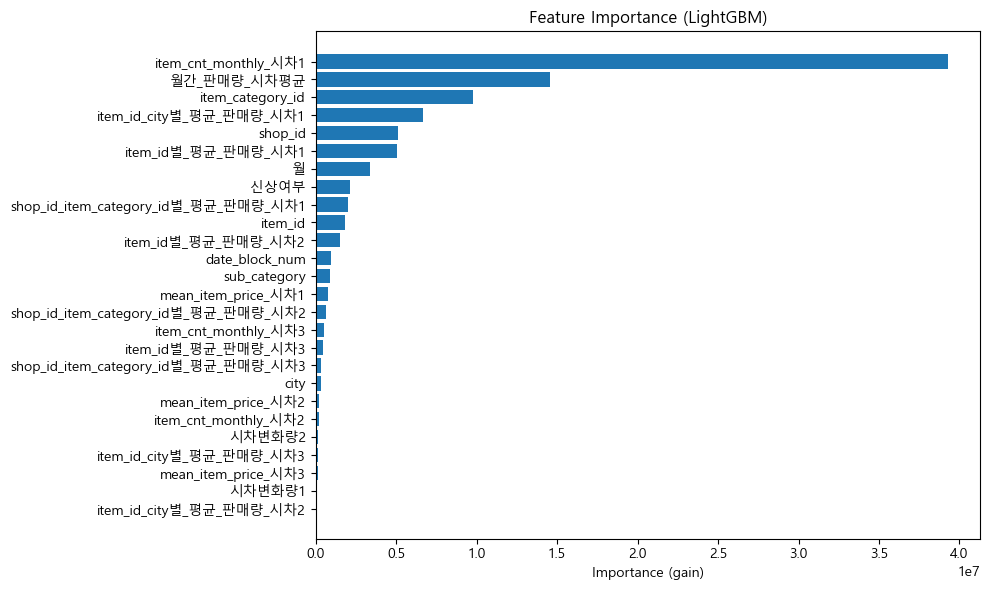

In [111]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. 중요도 데이터 추출
importance_df = pd.DataFrame({
    'feature': lgb_model.feature_name(),
    'importance': lgb_model.feature_importance(importance_type='gain')  # or 'split'
})

# 중요도 기준 내림차순 정렬
importance_df = importance_df.sort_values(by='importance', ascending=False)

# 2. 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel("Importance (gain)")
plt.title("Feature Importance (LightGBM)")
plt.gca().invert_yaxis()  # 가장 중요한 피처가 위로 오도록
plt.tight_layout()
plt.show()

- item_cnt_monthly_시차1 -> 가장 중요한 피처로 예측 성능에 가장 큰 영향
- 월간_판매량_시차평균, item_category_id, item_id_city별_평균_판매량_시차1 -> 유의미한 피처들
- item_id, sub_category, date_block_num 등 -> 기여도가 낮음 (삭제 고려 가능)

### 중요도가 낮은 피처 제거 후 실험해보기
- ex) 시차변화량1, 시차변화량2, item_id, mean_item_price_시차3 등 -> ➜ 불필요한 피처를 제거하면 노이즈가 감소하지 않을까?

In [88]:
# X_train에 있는 컬럼들 확인하기
print(X_train.columns.tolist())

['date_block_num', 'shop_id', 'item_id', 'city', 'item_category_id', 'item_cnt_monthly_시차1', 'item_cnt_monthly_시차2', 'item_cnt_monthly_시차3', 'mean_item_price_시차1', 'mean_item_price_시차2', 'mean_item_price_시차3', 'item_id별 평균 판매량_시차1', 'item_id별 평균 판매량_시차2', 'item_id별 평균 판매량_시차3', 'item_id city별 평균 판매량_시차1', 'item_id city별 평균 판매량_시차2', 'item_id city별 평균 판매량_시차3', 'shop_id item_category_id별 평균 판매량_시차1', 'shop_id item_category_id별 평균 판매량_시차2', 'shop_id item_category_id별 평균 판매량_시차3', '월간 판매량 시차평균', '시차변화량1', '시차변화량2', 'sub_category', '신상여부', '월']


#### try 1: 'item_id', '시차변화량1', '시차변화량2', 'mean_item_price_시차3', 'item_id city별 평균 판매량_시차2' -> 제거함

In [ ]:
low_importance_features = [
    'item_id', '시차변화량1', '시차변화량2',
    'mean_item_price_시차3', 'item_id city별 평균 판매량_시차2'
]

X_train = X_train.drop(columns=low_importance_features)
X_valid = X_valid.drop(columns=low_importance_features)

In [ ]:
import optuna
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import numpy as np

# Optuna objective 함수 정의
def objective(trial):
    # 하이퍼파라미터 공간 정의
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'force_col_wise': True,
        
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'early_stopping_rounds':50
    }

    # 데이터셋 준비
    dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    dvalid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)

    # 모델 학습
    model = lgb.train(
        param,
        train_set=dtrain,
        valid_sets=[dvalid],
        num_boost_round=1000   
        )

    # 예측 및 평가
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_valid, preds, squared=False)
    return rmse

# 최적화 실행
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

# 결과 출력
print("Best RMSE:", study.best_value)
print("Best hyperparameters:", study.best_params)

[I 2025-06-03 12:01:16,366] A new study created in memory with name: no-name-5d4a83ae-8873-4e84-82da-1784b15b03ba


[I 2025-06-03 12:04:19,416] Trial 0 finished with value: 0.8771982362648941 and parameters: {'num_leaves': 56, 'learning_rate': 0.1406188318576026, 'feature_fraction': 0.9167215957385184, 'bagging_fraction': 0.6833710037734722, 'bagging_freq': 3, 'min_data_in_leaf': 70}. Best is trial 0 with value: 0.8771982362648941.
[I 2025-06-03 12:14:58,243] Trial 1 finished with value: 0.8833084714828993 and parameters: {'num_leaves': 55, 'learning_rate': 0.01985079874238134, 'feature_fraction': 0.700888116898306, 'bagging_fraction': 0.6483504547891693, 'bagging_freq': 3, 'min_data_in_leaf': 57}. Best is trial 0 with value: 0.8771982362648941.
[I 2025-06-03 12:21:08,840] Trial 2 finished with value: 0.8789972246185634 and parameters: {'num_leaves': 35, 'learning_rate': 0.06616138997788612, 'feature_fraction': 0.8539907767964062, 'bagging_fraction': 0.6274152042464768, 'bagging_freq': 2, 'min_data_in_leaf': 13}. Best is trial 0 with value: 0.8771982362648941.
[I 2025-06-03 12:25:20,486] Trial 3 fin

Best RMSE: 0.8771982362648941
Best hyperparameters: {'num_leaves': 56, 'learning_rate': 0.1406188318576026, 'feature_fraction': 0.9167215957385184, 'bagging_fraction': 0.6833710037734722, 'bagging_freq': 3, 'min_data_in_leaf': 70}


#### try 2: try 1 + 제거할 피처 더 추가함 + 로그변환

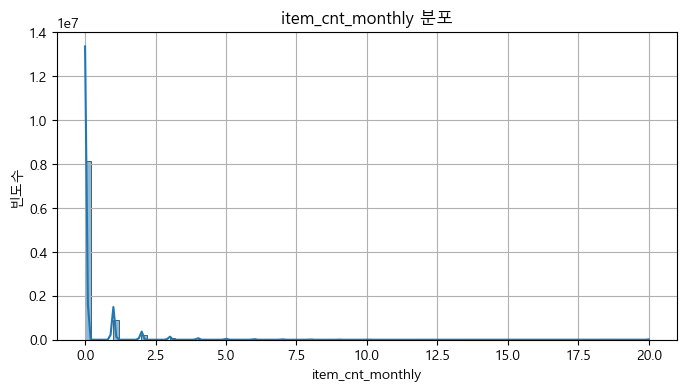

count    9.552744e+06
mean     2.946082e-01
std      1.212860e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.000000e+01
Name: item_cnt_monthly, dtype: float64


In [121]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 히스토그램 시각화
plt.figure(figsize=(8, 4))
sns.histplot(y_train, bins=100, kde=True)
plt.title("item_cnt_monthly 분포")
plt.xlabel("item_cnt_monthly")
plt.ylabel("빈도수")
plt.grid(True)
plt.show()

# 2. 기초 통계 확인
print(y_train.describe())

In [122]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_squared_error

# 1. 제거할 피처 정의
low_importance_features = [
    'item_id', '시차변화량1', '시차변화량2',
    'mean_item_price_시차3', 'item_id city별 평균 판매량_시차2',
    'item_id별 평균 판매량_시차3', 'shop_id item_category_id별 평균 판매량_시차3',
    'mean_item_price_시차2', 'city', 'sub_category', 'date_block_num'
]

# 2. 실제 존재하는 컬럼만 제거
existing_cols = [col for col in low_importance_features if col in X_train.columns]
X_train = X_train.drop(columns=existing_cols)
X_valid = X_valid.drop(columns=existing_cols)

# 3. 로그 변환된 타깃 생성
y_train_log = np.log1p(y_train)
y_valid_log = np.log1p(y_valid)

# 4. 범주형 변수 자동 필터링 및 타입 변환
cat_feature_candidates = ['shop_id', 'city', 'item_category_id', 'sub_category', '월']
cat_features = [col for col in cat_feature_candidates if col in X_train.columns]

for col in cat_features:
    X_train[col] = X_train[col].astype('category')
    X_valid[col] = X_valid[col].astype('category')

In [ ]:
# 5. Optuna 튜닝 함수 정의
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'force_col_wise': True,
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100)
    }

    dtrain = lgb.Dataset(X_train, label=y_train_log, categorical_feature=cat_features)
    dvalid = lgb.Dataset(X_valid, label=y_valid_log, categorical_feature=cat_features)

    model = lgb.train(
        params,
        train_set=dtrain,
        valid_sets=[dvalid],
        num_boost_round=500
    )

    preds = model.predict(X_test)
    rmse = mean_squared_error(y_valid, np.expm1(preds), squared=False)  # 역변환
    return rmse

# 6. Optuna 최적화 실행
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

# 7. 최적 결과 출력
print("Best RMSE:", study.best_value)
print("Best hyperparameters:", study.best_params)

# 8. 최종 모델 학습
best_params = study.best_params
best_params.update({
    'objective': 'regression',
    'metric': 'rmse',
    'random_state': 42,
    'force_col_wise': True
})

final_model = lgb.train(
    best_params,
    train_set=lgb.Dataset(X_train, label=y_train_log, categorical_feature=cat_features),
    valid_sets=[lgb.Dataset(X_valid, label=y_valid_log)],
    num_boost_round=1000
)

# 9. 최종 성능 평가 (역변환 후 RMSE)
final_preds = final_model.predict(X_test)
final_rmse = mean_squared_error(y_valid, np.expm1(final_preds), squared=False)
print("최종 Validation RMSE:", final_rmse)

[I 2025-06-03 13:12:52,553] A new study created in memory with name: no-name-9766c48b-b96e-4fda-9d46-1baf1140b5cc


[I 2025-06-03 13:15:41,808] Trial 0 finished with value: 0.9003275275789813 and parameters: {'num_leaves': 66, 'learning_rate': 0.14409783482125937, 'feature_fraction': 0.8897205552512158, 'bagging_fraction': 0.9359044483808298, 'bagging_freq': 7, 'min_data_in_leaf': 50}. Best is trial 0 with value: 0.9003275275789813.
[I 2025-06-03 13:18:25,826] Trial 1 finished with value: 0.9039292395959735 and parameters: {'num_leaves': 45, 'learning_rate': 0.11961573485318176, 'feature_fraction': 0.8291703621232878, 'bagging_fraction': 0.8543750883861142, 'bagging_freq': 8, 'min_data_in_leaf': 50}. Best is trial 0 with value: 0.9003275275789813.
[I 2025-06-03 13:21:26,229] Trial 2 finished with value: 0.8985548534678643 and parameters: {'num_leaves': 67, 'learning_rate': 0.10461370611592362, 'feature_fraction': 0.7732933360890939, 'bagging_fraction': 0.8755431043681499, 'bagging_freq': 7, 'min_data_in_leaf': 53}. Best is trial 2 with value: 0.8985548534678643.
[I 2025-06-03 13:24:32,162] Trial 3 f

Best RMSE: 0.8985548534678643
Best hyperparameters: {'num_leaves': 67, 'learning_rate': 0.10461370611592362, 'feature_fraction': 0.7732933360890939, 'bagging_fraction': 0.8755431043681499, 'bagging_freq': 7, 'min_data_in_leaf': 53}
최종 Validation RMSE: 0.8962850049150081


In [126]:
y_train.describe()

count    9.552744e+06
mean     2.946082e-01
std      1.212860e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.000000e+01
Name: item_cnt_monthly, dtype: float64

오히려 로그변환이 역효과가 났다.

#### try 3: try 1 + 제거할 피처 더 추가함 (로그변환 X)

In [127]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_squared_error

# 1. 제거할 중요도 낮은 피처 정의 (확장 버전)
low_importance_features = [
    'item_id',
    '시차변화량1',
    '시차변화량2',
    'mean_item_price_시차3',
    'item_id city별 평균 판매량_시차2',
    'item_id별 평균 판매량_시차3',
    'shop_id item_category_id별 평균 판매량_시차3',
    'mean_item_price_시차2',
    'city',
    'sub_category',
    'date_block_num'
]

# 2. 실제 존재하는 컬럼만 제거
existing_cols = [col for col in low_importance_features if col in X_train.columns]
X_train = X_train.drop(columns=existing_cols)
X_valid = X_valid.drop(columns=existing_cols)

# 3. 범주형 피처 설정
cat_feature_candidates = ['shop_id', 'city', 'item_category_id', 'sub_category', '월']
cat_features = [col for col in cat_feature_candidates if col in X_train.columns]

# 범주형 타입으로 변환
for col in cat_features:
    X_train[col] = X_train[col].astype('category')
    X_valid[col] = X_valid[col].astype('category')

In [129]:
# 4. Optuna 튜닝 objective 함수 정의
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'force_col_wise': True,
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100)
    }

    dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    dvalid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)

    model = lgb.train(
        params,
        train_set=dtrain,
        valid_sets=[dvalid],
        num_boost_round=500
    )

    preds = model.predict(X_valid)
    rmse = mean_squared_error(y_valid, preds, squared=False)
    return rmse

# 5. Optuna 최적화 실행
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

# 6. 결과 출력
print("Best RMSE:", study.best_value)
print("Best hyperparameters:", study.best_params)

[I 2025-06-03 14:19:05,191] A new study created in memory with name: no-name-e52426e2-545f-4af1-adfd-6708231dca9c


[I 2025-06-03 14:28:14,247] Trial 0 finished with value: 0.8891375710664481 and parameters: {'num_leaves': 38, 'learning_rate': 0.01586745812875428, 'feature_fraction': 0.8442519061034763, 'bagging_fraction': 0.8559629982243515, 'bagging_freq': 4, 'min_data_in_leaf': 59}. Best is trial 0 with value: 0.8891375710664481.
[I 2025-06-03 14:37:04,511] Trial 1 finished with value: 0.8862776285321845 and parameters: {'num_leaves': 25, 'learning_rate': 0.1174226830465199, 'feature_fraction': 0.7565720507557466, 'bagging_fraction': 0.8551155498622016, 'bagging_freq': 2, 'min_data_in_leaf': 93}. Best is trial 1 with value: 0.8862776285321845.
[I 2025-06-03 14:47:48,403] Trial 2 finished with value: 0.8872748345853617 and parameters: {'num_leaves': 98, 'learning_rate': 0.08279425598870227, 'feature_fraction': 0.8251313826070344, 'bagging_fraction': 0.9227029092764895, 'bagging_freq': 5, 'min_data_in_leaf': 100}. Best is trial 1 with value: 0.8862776285321845.
[I 2025-06-03 14:58:29,882] Trial 3 f

Best RMSE: 0.8836253747705748
Best hyperparameters: {'num_leaves': 50, 'learning_rate': 0.08023937370436432, 'feature_fraction': 0.7655108509469527, 'bagging_fraction': 0.9396796287727526, 'bagging_freq': 7, 'min_data_in_leaf': 49}


### try 1 코드 다시 가져와서 진행 (RMSE가 제일 작았던 모델)

In [105]:
# 1. 기준 모델 피처 구성 복사본 저장
X_train_base = X_train.copy()
X_valid_base = X_valid.copy()

In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

best_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'random_state': 42,
    'force_col_wise': True,
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'num_leaves': 64,
    'learning_rate': 0.07,
    'feature_fraction': 0.85,
    'bagging_fraction': 0.9,
    'bagging_freq': 5,
    'min_data_in_leaf': 20,
    'early_stopping_rounds':50,
    'verbose_eval':100
}

final_model = lgb.train(
    best_params,
    train_set=lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features),
    valid_sets=[lgb.Dataset(X_valid, label=y_valid)],
    num_boost_round=1000,
)

In [107]:
val_preds = final_model.predict(X_valid, num_iteration=final_model.best_iteration)
val_rmse = np.sqrt(mean_squared_error(y_valid, val_preds))

print("Best iteration:", final_model.best_iteration)
print("Best RMSE on validation set:", val_rmse)
# 여기까지가 학습/검증 데이터의 RMSE

Best iteration: 430
Best RMSE on validation set: 0.879796799960729


### 다시 시도

In [109]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# 1. 기준 피처 복사
X_train_base = X_train.copy()
X_valid_base = X_valid.copy()
X_test_base = X_test.copy()

# 2. 제거할 피처 정의 및 삭제 (존재하는 컬럼만)
candidate_features = [
    'item_id', '시차변화량1', '시차변화량2',
    'mean_item_price_시차3', 'item_id city별 평균 판매량_시차2'
]
drop_cols = [col for col in candidate_features if col in X_train_base.columns]

X_train = X_train_base.drop(columns=drop_cols)
X_valid = X_valid_base.drop(columns=drop_cols)
X_test = X_test_base.drop(columns=[col for col in drop_cols if col in X_test_base.columns])

# 3. 범주형 피처 정의 및 카테고리 기준 통일
cat_feature_candidates = ['shop_id', 'city', 'item_category_id', 'sub_category', '월']
cat_features = [col for col in cat_feature_candidates if col in X_train.columns]

for col in cat_features:
    combined = pd.concat([X_train[col], X_valid[col]])
    categories = combined.astype('category').cat.categories

    X_train[col] = pd.Categorical(X_train[col], categories=categories)
    X_valid[col] = pd.Categorical(X_valid[col], categories=categories)

    if col in X_test.columns:
        X_test[col] = pd.Categorical(X_test[col], categories=categories)

# 4. 피처 순서를 X_train 기준으로 맞춤 (feature shape error 방지)
X_test = X_test[X_train.columns]


In [110]:
# 5. 최적 파라미터로 LightGBM 학습
best_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'random_state': 42,
    'force_col_wise': True,
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'num_leaves': 64,
    'learning_rate': 0.07,
    'feature_fraction': 0.85,
    'bagging_fraction': 0.9,
    'bagging_freq': 5,
    'min_data_in_leaf': 20,
    'early_stopping_rounds': 50,
    'verbose_eval': 100
}

final_model = lgb.train(
    best_params,
    train_set=lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features),
    valid_sets=[lgb.Dataset(X_valid, label=y_valid)],
    num_boost_round=1000,
)

# 6. 검증 RMSE 평가
val_preds = final_model.predict(X_valid, num_iteration=final_model.best_iteration)
val_rmse = np.sqrt(mean_squared_error(y_valid, val_preds))
print("Best iteration:", final_model.best_iteration)
print("Best RMSE on validation set:", val_rmse)

Best iteration: 430
Best RMSE on validation set: 0.879796799960729


In [111]:
# 7. 테스트셋 예측
test_preds = final_model.predict(X_test, num_iteration=final_model.best_iteration)
print("Test predictions (sample):", test_preds[:10])

Test predictions (sample): [0.48296188 0.75362776 0.46019681 0.52965965 0.62521837 0.16319724
 0.56893232 1.23754428 2.63602094 0.10575697]


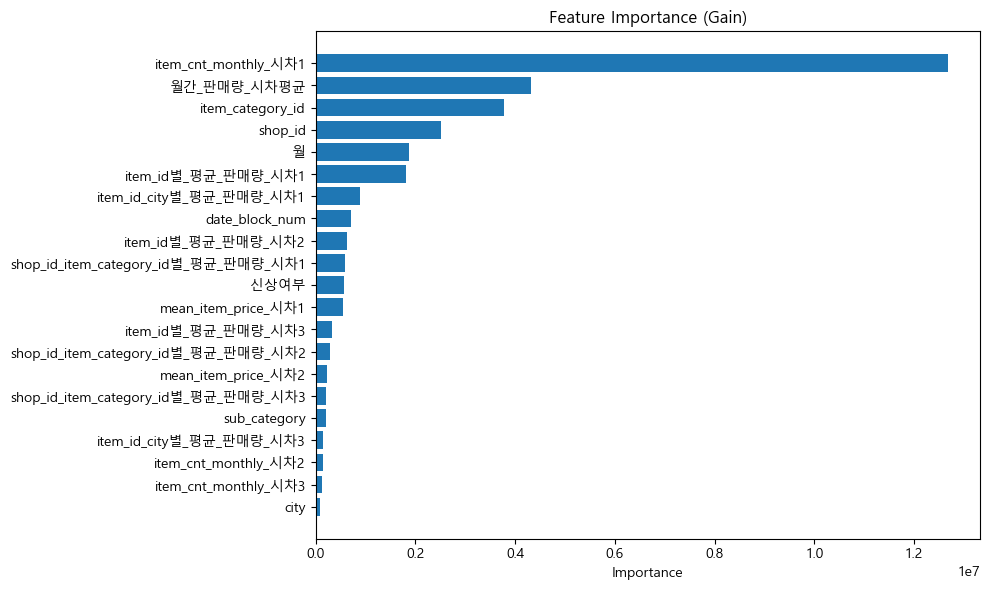

In [229]:
# Feature Importance 시각화
import matplotlib.pyplot as plt
import pandas as pd

importance_df = pd.DataFrame({
    'feature': final_model.feature_name(),
    'importance': final_model.feature_importance(importance_type='gain')
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.title("Feature Importance (Gain)")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [230]:
# (선택) 모델 저장
final_model.save_model("C:/Users/lynn9/Desktop/data/final_optuna_lightgbm_model.txt")